In [1]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

## Prerequisites

### Load Qiskit and Required Libraries

In [2]:
run_experiment = False
dynamical_decoupling = False

from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate, YGate
from qiskit.pulse import DriveChannel
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.providers.ibmq.managed import IBMQJobManager
import qiskit.quantum_info as qi

from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

from qiskit.opflow import (I, X, Y, Z, Zero, One, MatrixEvolution, PauliTrotterEvolution, Suzuki,
                           StateFn, Zero, One, PauliExpectation, PauliOp, SummedOp, OperatorBase)

from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import TemplateOptimization, ALAPSchedule, DynamicalDecoupling
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates

from qiskit.converters import circuit_to_dag, dag_to_circuit # for bespoke transpilation
from qiskit.dagcircuit import DAGCircuit, DAGNode

from qiskit.scheduler.config import ScheduleConfig
from qiskit.visualization import plot_circuit_layout, plot_error_map, timeline_drawer

import copy
import numpy as np
import scipy.linalg as lng
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

### Load IBM Quantum Account
Try Nick's then John's.

In [3]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
# backend = provider.get_backend('ibm_lagos')
backend = FakeMumbai()

### Load Backend Information (for Pulse)

In [4]:
# backend_config = backend.configuration()
# dt = backend_config.dt
# meas_map = backend_config.meas_map

# backend_defaults = backend.defaults()
# inst_sched_map = backend_defaults.instruction_schedule_map

# sched_config = ScheduleConfig(inst_sched_map, meas_map, dt)

# Build Circuits from Model Hamiltonian

## Define the System Hamiltonian

John wrote down the system Hamiltonian as

$$ H = \mu\sum_{i=0}^N c^{\dagger}_i c_i + t \sum_{i=0}^{N-1} (c^{\dagger}_ic_{i+1} + c^{\dagger}_{i+1}c_i) + \Delta \sum_{i=0}^{N-1}(c^{\dagger}_i c^{\dagger}_{i+1} + c_{i+1}c_i) + U \sum_{i=0}^{N-1} c^{\dagger}_i c_i c^{\dagger}_{i+1} c_{i+1} $$

where we can use the new `FermionicOp` class to write this general Hamiltonian for 2 site.

In terms of Majorana operators $\gamma^x_i = c^{\dagger}_i + c_i$ and $\gamma^y_i = i(c^{\dagger}_i - c_i)$ we have

$$ H = -\frac{2\mu + U}{4} \sum_{i=0}^N\gamma^x_i\gamma^y_i + \frac{t+\Delta}{2}\sum_{i=0}^{N-1} \gamma^x_i\gamma^y_{i+1} + \frac{t-\Delta}{2} \sum_{i=0}^{N-1} \gamma^y_i\gamma^x_{i+1} + \frac{U}{4}  \sum_{i=0}^{N-1}\gamma^x_i\gamma^y_i\gamma^x_{i+1}\gamma^y_{i+1}$$

In [5]:
hm = sum(FermionicOp(label) for label in ['IN', 'NI'])
ht = FermionicOp('+-') - FermionicOp('-+')
hD = FermionicOp('++') - FermionicOp('--')
hU = sum(FermionicOp(label) for label in ['NN'])

### Transform Fermionic to Pauli Hamiltonian
Bravyi-Kitaev and BKSuperFast are also built into Qiskit.

In [6]:
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper) # should not give 2-qubit reduction error

# parameters defined here due to incompatibility with Qiskit Nature
mu = Parameter('μ')
TT = Parameter('T')
DD = Parameter('Δ')
UU = Parameter('U')

hm_pauli = mu*(converter.convert(hm))
ht_pauli = TT*(converter.convert(ht))
hD_pauli = DD*(converter.convert(hD))
hU_pauli = UU*(converter.convert(hU))

ham_pauli = hm_pauli + ht_pauli + hD_pauli + hU_pauli
# print(ham_pauli)

## Build and Time Evolve Resonance Hamiltonian

Converting John's notation to little-endian:
$$H = -\frac{1}{2}\omega IIZ + H_{\rm Pauli}\otimes I + c IXX$$
Parsing in `opflow` is very dependent on how you build Hamiltonian.

In [7]:
from qiskit_research.spect_eigensolver.experiment import build_resonance_ham
cc = Parameter('c')
ww = Parameter('ω')
tt = Parameter('t')
res_ham = build_resonance_ham(ham_pauli, cc, ww)
U_ham = (tt*res_ham).exp_i()
# print(U_ham)


## Trotterize Unitary Evolution Operator
Why do random subcircuit appear sometimes? One hypothesis: parsing each coefficient with `Parameter`s expanded vs being multiplied by a grouping of `PauliOp`s might be it (observed this behavior at Heidelberg workshop).

In [8]:
# second-order Suzuki was used for manuscript
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(U_ham)
trot_circ = trot_op.to_circuit()
# trot_circ.draw(output='mpl', reverse_bits=True)

In [9]:
from mapomatic import evaluate_layouts, matching_layouts

best_layout = evaluate_layouts(trot_circ, 
                             matching_layouts(trot_circ, backend), backend)[0]
my_layout = best_layout[0]
my_score = best_layout[1]

print('Score is '+str(my_score)+' for layout '+str(my_layout))

Score is 0 for layout [1, 2, 4]


## Template Optimization and Basic Transpilation

/Users/nick/opt/anaconda3/envs/qiskit-research/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/nick/opt/anaconda3/envs/qiskit-research/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


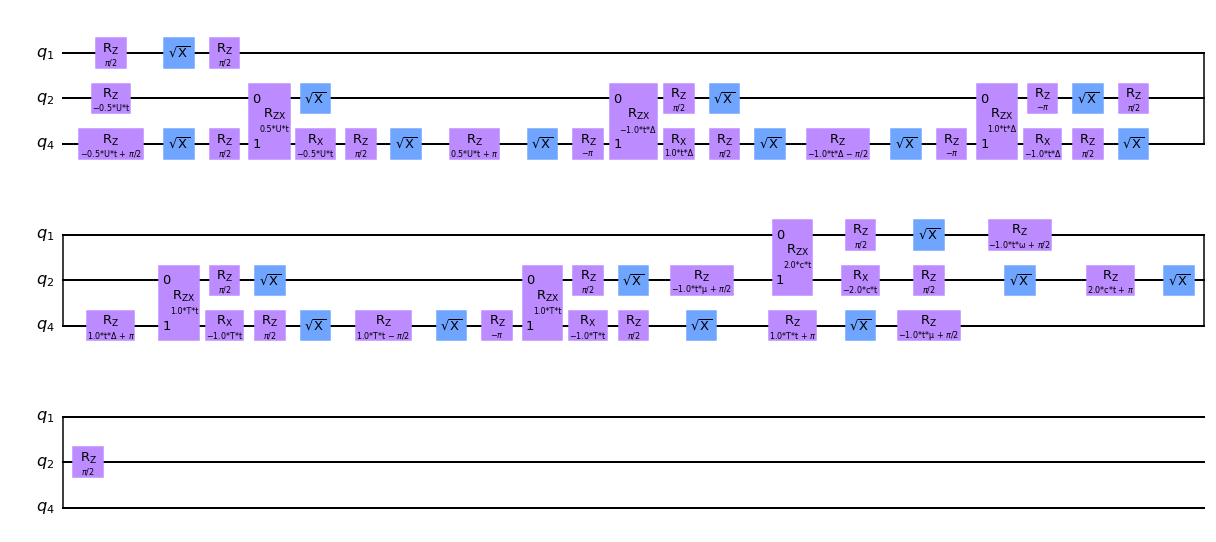

In [10]:
from qiskit_research.utils.convenience import scale_cr_pulses

basis_gates = ['rz', 'h', 'rx', 'cx']
trot_circ_t = scale_cr_pulses(transpile(trot_circ, 
            initial_layout=my_layout,
            basis_gates=basis_gates), backend, 
            force_zz_matches=True, # TODO: seems that this does not work for more complicated parameter expressions
            unroll_rzx_to_ecr=False)

trot_circ_t.draw('mpl', idle_wires=False)

# Build Sweep Experiment

In [11]:
from qiskit_research.spect_eigensolver.experiment import build_sweep

num_shots = 8192
model_params = {
    't_set': 5.0,
    'dt_set': 0.7,
    'c_set': 0.3,
    'x_set': 1.5,
    'y_set': 0.1,
    'z_set': 0.4,
}
m_range = np.linspace(-3, 3, 16)
w_range = np.linspace(-3.5, 3.5, 51)

final_circs_t = build_sweep(trot_circ_t, w_range, m_range, model_params, backend=backend)

> /Users/nick/Documents/codebase/qiskit-research/qiskit_research/utils/pulse_scaling.py(116)run()
    114         # TODO: Must this convert the DAG back to a QuantumCircuit?
    115         import pdb; pdb.set_trace()
--> 116         circuit = dag_to_circuit(dag)
    117         circuit.assign_parameters(self._param_bind, inplace=True)
    118         return circuit_to_dag(circuit)

> /Users/nick/Documents/codebase/qiskit-research/qiskit_research/utils/pulse_scaling.py(117)run()
    115         import pdb; pdb.set_trace()
    116         circuit = dag_to_circuit(dag)
--> 117         circuit.assign_parameters(self._param_bind, inplace=True)
    118         return circuit_to_dag(circuit)
    119 

ParameterView([Parameter(T), Parameter(U), Parameter(c), Parameter(t), Parameter(Δ), Parameter(μ), Parameter(ω)])
*** NameError: name 'Parameter' is not defined
*** qiskit.circuit.exceptions.CircuitError: 'Cannot bind parameters (T) not present in the circuit.'
*** IndentationError: expected an

## Set Model Hamiltonian Parameters

Grouping by terms, the Model Hamiltonian is written as
$$
H_{\rm Pauli} = -\frac{2\mu + U}{4} (IZ + ZI) + \frac{t+\Delta}{2} XX + \frac{t-\Delta}{2} YY + \frac{U}{4} ZZ \\
\equiv m(IZ + IZ) + x XX + y YY + z ZZ
$$
negelecting the identity term. 

In [ ]:
x_set = 1.5
# z_set = 0.2 # runs 1-4, 53-68, 209-224 (z semi-on!)
z_set = 0.0 # runs 5-20, 69-84, 101-103, 115-139, 225-240 (z off!)
# z_set = 0.4 # runs 21-52, 140-208, (z on!)
# z_set = -0.4 # runs 85-100 (z on and negative!)

### Invert Parameters before Binding

$$
t = x + y \qquad \Delta = x - y \qquad U = 4z \qquad \mu = -2(m+z)
$$

(This now happens differently in each param sweep step)

## Compare digital and scaled circuits

# Run on Quantum Hardware

In [ ]:


# Use Job Manager to break the circuits into multiple jobs.
job_manager = IBMQJobManager()
job_set_t5_nt1 = job_manager.run(final_circs_t, backend=backend, name='Ising-t{}-Nt{}'.format(stop_time, num_trot_steps))

job_id_t5_nt1 = job_set_t5_nt1.job_set_id()
print("Job Set ID: {}".format(job_id_t5_nt1))

In [ ]:
from qiskit.tools.monitor import job_monitor

if run_experiment:
    # run the job on a real backend
    if dynamical_decoupling:
        job = backend.run(res_circ_scaled_trans1 + res_circ_ddx2 + res_circ_ddxy4, 
                          job_name="SE_Eigensolver", meas_level=2, shots=8192)
    else:
        job = backend.run(res_circ_scaled_trans1, job_name="SE_Eigensolver", meas_level=2, shots=8192) 

    
    print(job.job_id())
    job_monitor(job)

## Or Retrieve from Previous Run

In [ ]:
if not run_experiment:
    # ntb default internal provider job ids
    job_ids_def = [
                  # y=0.4, m=1.0, c=0.4, z=0.2
                   '6134d974f8e62dc8e4a7bfed', # run 1 - t_sweep
                   '614141d26feb7e1aa36f5656', # run 2 - t_sweep
                   '6143af378eca75f46d42c806', # run 3 - t_sweep
                   '615097d12e79b36819d35e6e', # run 4 - c_sweep 
                   
                  # z=0 runs (off)
                   '615b59fcc97866325c08ff55', # run 5 - m_sweep, y=-1.5
                   '615b684a20df542ec45e3b52', # run 6 - m_sweep, y=-1.3
                   '615bc81720df5465eb5e400b', # run 7 - m_sweep, y=-1.1
                   '615bd258837ee41079c253b0', # run 8 - m_sweep, y=-0.9
                   '615bddb29f1b4a43d4ff7cd7', # run 9 - m_sweep, y=-0.7
                   '615be885da98d568592b90b5', # run 10 - m_sweep, y=-0.5
                   '615c8914837ee44fb3c259da', # run 11 - m_sweep, y=-0.3
                   '6160cd020fa7c30e31a26fce', # run 12 - m_sweep, y=-0.1
                   '6160da990fa7c32ddaa27035', # run 13 - m_sweep, y=0.3
                   '61617706d35e28a5db93d21f', # run 14 - m_sweep, y=0.3
                   '61618cd7d35e2800b793d284', # run 15 - m_sweep, y=0.5
                   '616236bfc978666c46093276', # run 16 - m_sweep, y=0.7
                   '6162ae9cfc7bdf39a143e79e', # run 17 - m_sweep, y=0.9
                   '6164ba8d9f1b4a48b0ffbb66', # run 18 - m_sweep, y=1.1
                   '6164c762ed29dd5a5ec69776', # run 19 - m_sweep, y=1.3
                   '616544f2ed29dd485fc69b9f', # run 20 - m_sweep, y=1.5
    
                  # z=0.4 runs (on)
                   '616ac829e4cd1779b14b3ddb', # run 21 - m_sweep, y=-1.5
                   '616c03c682ec5a4008ddfb88', # run 22 - m_sweep, y=-1.3
                   '616ca052540eb274f628c895', # run 23 - m_sweep, y=-1.1
                   '616d48d3f21fcaeb037754fe', # run 24 - m_sweep, y=-0.9
                   '61701ccc9c88ce3e40b0e94b', # run 25 - m_sweep, y=-0.7
                   '617028da43727303b3987d8a', # run 26 - m_sweep, y=-0.5
                   '6170427a7c5dd5042afd2c3a', # run 27 - m_sweep, y=-0.3, re-started notebook (updated inst_sched_map)
                   '61704eee78399c3a6550430f', # run 28 - m_sweep, y=-0.1
                   '61705b16437273463f987ead', # run 29 - m_sweep, y=0.1
                   '617069ac437273c21e987efc', # run 30 - m_sweep, y=0.3
                   '617078907c5dd5d51ffd2d72', # run 31 - m_sweep, y=0.5
                   '617083b8ac4af566ce5a704b', # run 32 - m_sweep, y=0.7
                   '61708ee9dd30e9613de61df5', # run 33 - m_sweep, y=0.9
                   '6170cf1ccea63368481457e1', # run 34 - m_sweep, y=1.1
                   '617147fe9c88ce1f75b0ef87', # run 35 - m_sweep, y=1.3
                   '617157191cc68170e998717c', # run 36 - m_sweep, y=1.5
    
                  # z=0.4, dt_set=0.7
                   '6178374b2e5f445f3fcb2658', # run 37 - m_sweep, y=-1.5
                   '617844fb6ba9a855d003dd4a', # run 38 - m_sweep, y=-1.3
                   '61785e03ece07e62c10ebed1', # run 39 - m_sweep, y=-1.1
                   '61786f8b1286f275b142184a', # run 40 - m_sweep, y=-0.9
                   '61787dd656f4d7fe0d46ae76', # run 41 - m_sweep, y=-0.7
                   '6178a2cf0080172e4b4f2918', # run 42 - m_sweep, y=-0.5
                   '6178aeb5ece07e97770ec24d', # run 43 - m_sweep, y=-0.3
                   '6178bbfc11395bfd151c4d86', # run 44 - m_sweep, y=-0.1
                   '6178c9b156f4d7233046b19c', # run 45 - m_sweep, y=0.1
                   '6178d75eece07e3d5a0ec4b2', # run 46 - m_sweep, y=0.3
                   '61793cd476b55a37f0afb0c8', # run 47 - m_sweep, y=0.5
                   '6179493ab851bf00930d20fc', # run 48 - m_sweep, y=0.7
                   '617957222e5f4451cfcb33de', # run 49 - m_sweep, y=0.9
                   '61797e0119bc9c65ec82fc1f', # run 50 - m_sweep, y=1.1
                   '6179926abc9884d8485f8cf4', # run 51 - m_sweep, y=1.3
                   '6179b31c19bc9c08b482fd8d'] # run 52 - m_sweep, y=1.5
    
    # z=0.2, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
    job_ids_crit = ['618c1c4518014be18ad2adbe', # run 53 - m_sweep, y=-1.5
                    '618c2c8efa93429c778ac41f', # run 54 - m_sweep, y=-1.3
                    '618c4115fa934243108ac4d1', # run 55 - m_sweep, y=-1.1
                    '618c7e3afa93425ec58ac643', # run 56 - m_sweep, y=-0.9
                    '618c848d3b109c0483477918', # run 57 - m_sweep, y=-0.7
                    '618c86a72ab8f59ab6622e61', # run 58 - m_sweep, y=-0.5
                    '618c893218014b4609d2b0d4', # run 59 - m_sweep, y=-0.3
                    '618c8b8b18014b5b2fd2b0e6', # run 60 - m_sweep, y=-0.1
                    '618c8dee9880afc3cdc0ffe5', # run 61 - m_sweep, y=0.1
                    '618c900748856a0f34edafbb', # run 62 - m_sweep, y=0.3
                    '618c923d3b109c1c1547794f', # run 63 - m_sweep, y=0.5
                    '618c95a8fa934200318ac6ba', # run 64 - m_sweep, y=0.7
                    '618c97e99880af1fe9c10012', # run 65 - m_sweep, y=0.9
                    '618c9a06e6cb0990eb6353cd', # run 66 - m_sweep, y=1.1
                    '618c9ce58b10e72e3968d4f6', # run 67 - m_sweep, y=1.3
                    '618c9f5318014b7af8d2b134', # run 68 - m_sweep, y=1.5
    
                  # z=0.0, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '618d1e98fc46da9adb8e449f', # run 69 - m_sweep, y=-1.5
                    '618d21a60b2c123cdd6fe67a', # run 70 - m_sweep, y=-1.3
                    '618d23b9944d5dfd6baa7c0e', # run 71 - m_sweep, y=-1.1
                    '618d3abb2b0346846de1044e', # run 72 - m_sweep, y=-0.9
                    '618d3ebdfc46da52818e45da', # run 73 - m_sweep, y=-0.7
                    '618d41eb1fe02d691ac3c150', # run 74 - m_sweep, y=-0.5
                    '618d4420fc46da7e578e460d', # run 75 - m_sweep, y=-0.3
                    '618d476f9c22c361d6e5edfb', # run 76 - m_sweep, y=-0.1
                    '618d49f06bc1dd0e0093df68', # run 77 - m_sweep, y=0.1
                    '618d5584cc669a3eb2d2db45', # run 78 - m_sweep, y=0.3
                    '618d704c56c9100e1e703eca', # run 79 - m_sweep, y=0.5
                    '618d74390b2c125d2a6feacc', # run 80 - m_sweep, y=0.7
                    '618d76829c22c34cb9e5f125', # run 81 - m_sweep, y=0.9
                    '618d78ea944d5d4b95aa809e', # run 82 - m_sweep, y=1.1
                    '618d7b482b03466eb3e107e2', # run 83 - m_sweep, y=1.3
                    '618d7f5ccc669a7f15d2de36', # run 84 - m_sweep, y=1.5
    
                  # z=-0.4, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '6193fa73e2f5b6eaf668bb81', # run 85 - m_sweep, y=-1.5
                    '619400b1329f0fcecb48ff9b', # run 86 - m_sweep, y=-1.3
                    '619403696254ddbb65864dc3', # run 87 - m_sweep, y=-1.1
                    '61940b3bbd3c6c8facf93d9e', # run 88 - m_sweep, y=-0.9
                    '61940e982be06d53e3031457', # run 89 - m_sweep, y=-0.7
                    '619416e39d052aedb08b60e2', # run 90 - m_sweep, y=-0.5
                    '61942bed2be06d747b031563', # run 91 - m_sweep, y=-0.3
                    '61942e89a90bff28ea2618fc', # run 92 - m_sweep, y=-0.1
                    '6194360a9e1846348bb66019', # run 93 - m_sweep, y=0.1
                    '619438f6bd3c6cabc9f93f4f', # run 94 - m_sweep, y=0.3
                    '61943bd6972490e25893ad03', # run 95 - m_sweep, y=0.5
                    '61943ffd9d052a5ed18b6259', # run 96 - m_sweep, y=0.7
                    '61944665972490be1293ada1', # run 97 - m_sweep, y=0.9
                    '61944bc39e1846f279b6613c', # run 98 - m_sweep, y=1.1
                    '61944f60329f0ffd774902c5', # run 99 - m_sweep, y=1.3
                    '619464f49d052ab2ff8b6410', # run 100 - m_sweep, y=1.5
    
                  # z=0.0, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 4-5-6
                    '6195e4699e1846f410b66ceb', # run 101 - c_sweep, y=0, m=0
                    '61967f1e972490061893bc00', # run 102 - c_sweep, y=0.1, m=0.1
    
                  # z=0.0, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '61993d388b720eaf9c115002', # run 103 - c_sweep, y=0.1, m=0.1
    
                  # m=0.0, c=0.3, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '61995d1e68476d66ef8a7d2a', # run 104 - y_sweep, z=-0.5
                    '619962005297baad34ecbbec', # run 105 - y_sweep, z=-0.4
                    '61996585cd37f3a2a3f268c9', # run 106 - y_sweep, z=-0.3
                    '61996851580e75146a14e9ad', # run 107 - y_sweep, z=-0.2
                    '61996b0a580e756af214e9be', # run 108 - y_sweep, z=-0.1
                    '619972508b720ead5e115124', # run 109 - y_sweep, z=0.0
                    '619975becd37f37687f2692b', # run 110 - y_sweep, z=0.1
                    '61997dbbcd37f39f02f2694c', # run 111 - y_sweep, z=0.2
                    '6199821a5297ba3f51ecbc9f', # run 112 - y_sweep, z=0.3
                    '619985648982d9e42f33858a', # run 113 - y_sweep, z=0.4
                    '61998a1d68476d08438a7e2a', # run 114 - y_sweep, z=0.5
    
                  # y=0.1, m=0.1, c=0.3 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '619e85ed580e756b62150f3c', # run 115 - t_sweep, z=0.0
    
                  # m=0.0, c=0.3, dt_set=0.1, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                  # z=0.0, noDD + X2 + XY4
                    '61a3f4805ddc02a92fe74b35', #run 116 - y_sweep -1.5 to -1.3
                    '61a3f8efe76c00841afa3e18', # run 117 - y_sweep -1.1 to -0.7
                    '61a3fd32fd3a881c19590d7e', # run 118 - y_sweep -0.5 to -0.1
                    '61a405cecbd50667abff0919', # run 119 - y_sweep 0.1 to 0.5
                    '61a4098683753d300027c668', # run 120 - y_sweep 0.7 to 1.1
                    '61a40c0fe76c00304afa3e68', # run 121 - y_sweep 1.3 to 1.5
                    '61a553a46a8ec04f82197eba', # run 122 - y_sweep redo -1.5 to -1.3
    
                  # z=0.0, c=0.3, dt_set=0.1, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '61a67b4a44185e542416c37b', # run 123 - m_sweep, y=0.1, m=-0.1, 0, 0.1
                    '61a9313ceeb4d473cdb075f2', # run 124 - m_sweep, y=0.1, m=-0.1, 0, 0.1 noDD passes
                    
                  # runs 125-127 failed due to backend job dispatcher issue, which continues for a few runs below
                    '', # run 125
                    '', # run 126
                    '', # run 127
                    
                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2 (redo)
                  # z=0.0, noDD + X2 + XY4
                    '61b38d11a43b0c79052af305', # run 128 - y_sweep -1.5 to -0.7
                    '61b9125b58158fc29bb6588f', # run 129 y_sweep -0.5 to 0.3 - CANCELED AFTER RUNNING 6 DAYS
                    '61b9287315ab795582b85d7e', # run 130 - y_sweep 0.5 to 1.3 - CANCELED AFTER RUNNING 6 DAYS
                    '61b64cdf33cebdd08a2b14d5', # run 131 - y_sweep 1.5 
    
                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2 (redo again)
                  # z=0.0, noDD + X2 + XY4
                    '61c36c8c06d47f3210c40853', # run 132 - y_sweep -1.5 to -0.9
                    '61c36db681db3e6e0084ef5b', # run 133 - y_sweep -0.7 to -0.1
                    '61c36e9be2b9d14fdc91222f', # run 134 - y_sweep 0.1 to 0.7
                    '61c370b006d47fa445c40867', # run 135 - y_sweep 0.9 to 1.5
                    
                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2 (redo)
                  # z=0.0, noDD + X2 + XY4  
                  # redo again with just ancilla probe measurement, qubits 2-1-0
                    '61c49b445763548ad5f4fece', # run 136 - y_sweep -1.5 to -0.9
                    '61c49f5481db3ef02884f4b7', # run 137 - y_sweep -0.7 to -0.1
                    '61c4a0eb06d47f2b8ac40dac', # run 138 - y_sweep 0.1 to 0.7
                    '61c4a3b9576354c6d5f4feed', # run 139 - y_sweep 0.9 to 1.5
    
                  #z=0.4, dt_set=0.7, no DD, (NOT) single meas - MISSION CRITICAL PROVIDER, qubits 2-1-0
                  #THESE JOBS DO NOT SEEM TO BE BUILT CORRECTLY (153 circuits each?)
                    '61c64cb23b6df90e4273d848', # run 140 - m_sweep, y=-1.5
                    '61c64ded06d47fc247c4150d', # run 141 - m_sweep, y=-1.3
                    '61c64e9f255d4eff69d65400', # run 142 - m_sweep, y=-1.1
                    '61c64f3ba81fcf70ddd1cdf4', # run 143 - m_sweep, y=-0.9
                    '61c65110255d4e6242d6540c', # run 144 - m_sweep, y=-0.7
                    '61c651ad20e2c478beeaed2c', # run 145 - m_sweep, y=-0.5
                    '61c65269a81fcfba19d1cdf8', # run 146 - m_sweep, y=-0.3
                    '61c6530a06d47f71a6c4151f', # run 147 - m_sweep, y=-0.1
                    '61c653a3525f9ebfcd396399', # run 148 - m_sweep, y=0.1
                    '61c654c406d47f3f24c41521', # run 149 - m_sweep, y=0.3
                    '61c655a2e2b9d14243912f2e', # run 150 - m_sweep, y=0.5
                    '61c65773576354ecaff5064f', # run 151 - m_sweep, y=0.7
                    '61c6582a3b6df944a773d866', # run 152 - m_sweep, y=0.9
                    '61c658cf3b6df90a2273d868', # run 153 - m_sweep, y=1.1
                    '61c6598c3b6df9468c73d86e', # run 154 - m_sweep, y=1.3
                    '61c65a33a81fcf62cad1ce15', # run 155 - m_sweep, y=1.5
    
                  #z=0.4, dt_set=0.7, no DD, single meas - MISSION CRITICAL PROVIDER, qubits 2-1-0
                    '61c88da5525f9e6c03396cfd', # run 156 - m_sweep, y=-1.5
                    '61c88fa23b6df9efaf73e1c5', # run 157 - m_sweep, y=-1.3 - CANCELED
                    '61c8919406d47f0c22c41e62', # run 158 - m_sweep, y=-1.1 - CANCELED
                    '61c89388fa27f6330437cd8e', # run 159 - m_sweep, y=-0.9 - CANCELED
                    '61c895725763546712f50fa7', # run 160 - m_sweep, y=-0.7 - CANCELED
                    '61c8976d525f9e0b22396d24', # run 161 - m_sweep, y=-0.5 - CANCELED
                    '61c89ac5255d4ea33ad65d8e', # run 162 - m_sweep, y=-0.3
                    '61c8c63781db3e3f2a8507a5', # run 163 - m_sweep, y=-0.1 - CANCELED
                    '61c8c8cfa81fcfbefcd1d842', # run 164 - m_sweep, y=0.1 - CANCELED
                    '61c8cae206d47fe1f1c41f6f', # run 165 - m_sweep, y=0.3 - CANCELED
                    '61c908653b6df96f9373e37f', # run 166 - m_sweep, y=0.5 - CANCELED
                    '61c90b2ea81fcf35bed1d91a', # run 167 - m_sweep, y=0.7 - CANCELED
                    '61c90d4a06d47f111ac42049', # run 168 - m_sweep, y=0.9 - CANCELED
                    '61c90f6606d47f3563c4204e', # run 169 - m_sweep, y=1.1 - CANCELED
                    '61c9116581db3ef39b8508ce', # run 170 - m_sweep, y=1.3 - CANCELED
                    '61c9135cfa27f68c3b37cf52', # run 171 - m_sweep, y=1.5 - CANCELED
    
                  #z=0.4, dt_set=0.7, no DD, single meas - MISSION CRITICAL PROVIDER, qubits 2-1-0
                    '61ca03c13b6df9a02173e6d0', # run 172 - m_sweep, y=-1.3 retry - CANCELED
                    '61cb5c3ae2b9d1816c914240', # run 173 - m_sweep, y=-1.5 - CANCELED
                  # runs 174-188 never executed due to dispatcher issues
                    '', # run 174
                    '', # run 175
                    '', # run 176
                    '', # run 177
                    '', # run 178
                    '', # run 179
                    '', # run 180
                    '', # run 181
                    '', # run 182
                    '', # run 183
                    '', # run 184
                    '', # run 185
                    '', # run 186
                    '', # run 187
                    '', # run 188

                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 2-1-0
                  # z=0.4, noDD + X2 + XY4, fixed rzx timing issue (which may have effected DD)
                    '61ce04e4fa27f692da37e282', # run 189 - y_sweep -1.5 to -0.9
                    '61d48634a81fcf85c2d1fe42', # run 190 - y_sweep -0.7 to -0.1
                    '61d488f4a81fcf9048d1fe48', # run 191 - y_sweep 0.1 to 0.7
                    '61d48e3bf24655412c32188f', # run 192- y_sweep 0.9 to 1.5

                  # z=0.4, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
                    '61dd84f58cd5fc403e46aa02', # run 193 - m_sweep, y=-1.5
                    '61dd877c8df39446a733150c', # run 194 - m_sweep, y=-1.3
                    '61dd89899307b9d55c6bc734', # run 195 - m_sweep, y=-1.1
                    '61dd8bfbfde78bdc64dbb70f', # run 196 - m_sweep, y=-0.9
                    '61dd8eb687d4f81a1f23fbd6', # run 197 - m_sweep, y=-0.7
                    '61dd91c08df394771c331547', # run 198 - m_sweep, y=-0.5
                    '61ddc35c8cd5fc172746aafa', # run 199 - m_sweep, y=-0.3
                    '61ddc5e00a744aba1199d15e', # run 200 - m_sweep, y=-0.1
                    '61ddc8ec9710ff9796ddf232', # run 201 - m_sweep, y=0.1
                    '61ddcb199307b947326bc854', # run 202 - m_sweep, y=0.3
                    '61ddcde49307b90c806bc85f', # run 203 - m_sweep, y=0.5
                    '61ddd08d6d650863301a1d7a', # run 204 - m_sweep, y=0.7
                    '61ddd2e46d6508358d1a1d8a', # run 205 - m_sweep, y=0.9
                    '61ddd50d87d4f8c4b923fcf3', # run 206 - m_sweep, y=1.1
                    '61dde83a6d65083ff41a1e1a', # run 207 - m_sweep, y=1.3
                    '61ddeb370a744a647299d24a', # run 208 - m_sweep, y=1.5
    
                  # z=0.2, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
                    '61df2a3a9710ff287dddf6ff', # run 209 - m_sweep, y=-1.5
                    '61df2dd4d1eb07e0264932f5', # run 210 - m_sweep, y=-1.3
                    '61df316dfde78b7054dbbcc6', # run 211 - m_sweep, y=-1.1
                    '61df3a7787d4f8eba8240171', # run 212 - m_sweep, y=-0.9
                    '61df3d00d1eb0724ae49330f', # run 213 - m_sweep, y=-0.7
                    '61df51809710ff7051ddf73f', # run 214 - m_sweep, y=-0.5
                    '61df5566fde78b1e13dbbd16', # run 215 - m_sweep, y=-0.3
                    '61df584487d4f8165c2401a3', # run 216 - m_sweep, y=-0.1
                    '61df5b3b0a744a90ea99d659', # run 217 - m_sweep, y=0.1
                    '61df5dbf9307b9f11f6bcd4d', # run 218 - m_sweep, y=0.3
                    '61df61dd8df3946094331b14', # run 219 - m_sweep, y=0.5
                    '61df65b00a744a5f9399d682', # run 220 - m_sweep, y=0.7
                    '61df685cd1eb07f6b0493371', # run 221 - m_sweep, y=0.9
                    '61df6add8df39466d9331b27', # run 222 - m_sweep, y=1.1
                    '61df6e7d87d4f82c802401d5', # run 223 - m_sweep, y=1.3
                    '61df71e89307b908636bcd79', # run 224 - m_sweep, y=1.5
    
                  # z=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
                    '61df7523fde78b4a71dbbd59', # run 225 - m_sweep, y=-1.5
                    '61df78fb8df39432de331b3c', # run 226 - m_sweep, y=-1.3
                    '61df7c108df394390d331b43', # run 227 - m_sweep, y=-1.1
                    '61df7f640a744ac79b99d6c2', # run 228 - m_sweep, y=-0.9
                    '61df824333a1ee7a63f16ff1', # run 229 - m_sweep, y=-0.7
                    '61df85130a744a793d99d6c7', # run 230 - m_sweep, y=-0.5
                    '61df87889307b93ddc6bcd99', # run 231 - m_sweep, y=-0.3
                    '61df8a4cd1eb075e474933b1', # run 232 - m_sweep, y=-0.1
                    '61df8d396113fa81305a7eea', # run 233 - m_sweep, y=0.1
                    '61df8fc733a1ee952ff16ffd', # run 234 - m_sweep, y=0.3
                    '61df92736113fa73f35a7eee', # run 235 - m_sweep, y=0.5
                    '61df9524d1eb0765544933bc', # run 236 - m_sweep, y=0.7
                    '61df97d987d4f810f8240208', # run 237 - m_sweep, y=0.9
                    '61df9ab733a1eeb07ff1700c', # run 238 - m_sweep, y=1.1
                    '61df9d9b87d4f8820524020d', # run 239 - m_sweep, y=1.3
                    '61dfa01533a1eed8f7f17025'] # run 240 - m_sweep, y=1.5

In [ ]:
run_num = 240
if run_num < 53:
    job = backend.retrieve_job(job_ids_def[run_num-1])
else:
    job = backend.retrieve_job(job_ids_crit[run_num-53])

In [ ]:
Result = job.result().get_counts()

# Analyze Results

In [ ]:
if exp_str == 't_sweep':
    t_analyze = 10.0
    dt_analyze = 1.0

    tidx = int(np.where(np.round(np.asarray(t_range), 2) == t_analyze)[0])
    dtidx = int(np.where(np.round(np.asarray(dt_range), 2) == dt_analyze)[0])

    w0 = w_range[0]
    idx0 = dtidx*len(w_range) + tidx*len(w_range)*(1+len(t_range)) # starting index
    pd0 = ['t='+str(round(t_analyze, 2))+', dt='
           +str(round(dt_analyze, 2))+', w='+str(round(w0, 2))] 
    pdf = ['t='+str(round(t_analyze, 2))+', dt='
           +str(round(dt_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'c_sweep':
    c_analyze = 0.03
    cidx = int(np.where(np.round(np.asarray(c_range), 2) == c_analyze)[0])
    idx0 = cidx*len(w_range) # starting index
    pd0 = ['c='+str(round(c_analyze, 2))+', w='+str(round(w0, 2))]
    pdf = ['c='+str(round(c_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'm_sweep':
    m_analyze = -1.5
    param_bind[mu] = -2*(m_analyze + z_set)
    midx = int(np.where(np.round(np.asarray(m_range), 2) == m_analyze)[0])
    idx0 = midx*len(w_range) # starting index
    w0 = w_range[0]
    dw = round(w_range[1] - w_range[0], 2)
    pd0 = ['y='+str(round(y_set, 2))+', m='+str(round(m_analyze, 2))+', w='+str(round(w0, 2))]
    pdf = ['y='+str(round(y_set, 2))+', m='+str(round(m_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'y_sweep':
    y_analyze = -1.5
    param_bind[TT] = x_set + y_analyze
    param_bind[DD] = x_set - y_analyze
    yidx = int(np.where(np.round(np.asarray(y_range), 2) == y_analyze)[0])
    idx0 = yidx*len(w_range) # starting index
    w0 = w_range[0]
    dw = round(w_range[1] - w_range[0], 2)
    pd0 = ['y='+str(round(y_set, 2))+', z='+str(round(z_set, 2))+', w='+str(round(w0, 2))]
    pdf = ['y='+str(round(y_set, 2))+', z='+str(round(z_set, 2))+', w='+str(round(-w0, 2))]

## Simulation for Analysis

In [ ]:
wi0 = param_decoder.index(pd0)
wif = param_decoder.index(pdf)

# energies = np.linspace(w0, -w0, int(-2*w0/dw)+1) # w0 is negative
energies = w_range

In [ ]:
gnd_state = Zero^3 # |000>
obsv = I^I^Z
evo_and_obsv = (U_ham @ gnd_state).adjoint() @ obsv @ U_ham @ gnd_state

### Diagonalization of Pauli Hamiltonian

In [ ]:
evalues, evects = lng.eig(ham_pauli.bind_parameters(param_bind).to_matrix())

# The expected transitions
D0 = [evalues[i]-evalues[0] for i in range(0,3)]
D1 = [evalues[i]-evalues[1] for i in range(0,3)]
D2 = [evalues[i]-evalues[2] for i in range(0,3)]
D3 = [evalues[i]-evalues[3] for i in range(0,3)]
print(D0, D1, D2, D3)

[0j, (-6.000000000000002+0j), (-6.000000000000002+0j)] [(6.000000000000002+0j), 0j, (-5.639463903503843e-33+0j)] [(6.000000000000002+0j), (5.639463903503843e-33+0j), 0j] [(1.7763568394002505e-15+0j), (-6+0j), (-6+0j)]


### Qiskit Statevector Evolution (of Resonance Ham)

In [ ]:
res_circ_scaled_trans[wi0].remove_final_measurements()
psi = qi.Statevector.from_instruction(res_circ_scaled_trans[wi0]).data

q0 = initial_layout[0]
Nq = int(np.log2(len(psi)))
Z_label = ''
for q in range(Nq):
    if q == Nq - 1 - q0:
        Z_label = Z_label + 'Z'
    else:
        Z_label = Z_label + 'I'
Z0 = qi.Operator.from_label(Z_label).data

ParameterTypeError: ParameterExpression with unbound parameters ({Parameter(μ), Parameter(U), Parameter(t)}) cannot be cast to a float.

In [ ]:
param_bind[tt] = dt_set
try:
    param_bind[cc] = c_analyze
except:
    param_bind[cc] = c_set

prob0_final = []
for wi in range(wi0,wif+1):    
    res_circ_scaled_trans[wi].remove_final_measurements()
    psi = qi.Statevector.from_instruction(res_circ_scaled_trans[wi]).data
    P0 = np.dot(np.conjugate(psi),np.dot(Z0,psi))
    prob0_final.append(P0)

In [ ]:
# res_circ_ddx2[wi0].remove_final_measurements()
# psi = qi.Statevector.from_instruction(res_circ_ddx2[wi0]).data

# q0 = initial_layout[0]
# Nq = int(np.log2(len(psi)))
# Z_label = ''
# for q in range(Nq):
#     if q == Nq - 1 - q0:
#         Z_label = Z_label + 'Z'
#     else:
#         Z_label = Z_label + 'I'
# Z0 = qi.Operator.from_label(Z_label).data

In [ ]:
# param_bind[tt] = dt_set
# try:
#     param_bind[cc] = c_analyze
# except:
#     param_bind[cc] = c_set

# prob0_final = []
# for wi in range(wi0,wif+1):    
#     res_circ_ddx2[wi].remove_final_measurements()
#     psi = qi.Statevector.from_instruction(res_circ_ddx2[wi]).data
#     P0 = np.dot(np.conjugate(psi),np.dot(Z0,psi))
#     prob0_final.append(P0)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,5))
# ax.plot(energies, np.real(prob0_final), label='Circuit Evol',linewidth=6)

### numpy Matrix Evolution

In [ ]:
prob0_matrix = []
Z0 = obsv.to_matrix()
for w_set in energies:
    HM = res_ham.bind_parameters({**param_bind, ww: w_set}).to_matrix()
    psiM = gnd_state.to_matrix()
    psiM_f = np.dot(lng.expm(-1j*HM*t_set), psiM)

    prob0_matrix.append(np.dot(np.conjugate(psiM_f), np.dot(Z0,psiM_f)))

### Opflow Exact Evolution

In [ ]:
param_bind[tt] = int(t_set/dt_set)*dt_set
diag_meas_op = PauliExpectation().convert(evo_and_obsv.bind_parameters(param_bind))

prob0_exact = []
for w_set in energies:
    simple_ham_exps = diag_meas_op.bind_parameters({ww: w_set})
    prob0_exact.append(simple_ham_exps.eval())

### Opflow Trotter Evolution

In [ ]:
if exp_str == 't_sweep':
    trot_steps = int(t_analyze/dt_analyze)
elif exp_str == 'c_sweep':
    trot_steps = int(t_set/dt_set)
elif exp_str == 'm_sweep':
    trot_steps = int(t_set/dt_set)
elif exp_str == 'y_sweep':
    trot_steps = int(t_set/dt_set)
    
sim_trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=trot_steps)).convert(evo_and_obsv)

In [ ]:
diag_meas_op = PauliExpectation().convert(sim_trot_op.bind_parameters(param_bind))
simple_ham_exps = diag_meas_op.bind_parameters({ww: list(energies)})
prob0_amp_trot = simple_ham_exps.eval()

prob0_trot = []
for eidx,_ in enumerate(energies):
    #prob0_trot.append(prob0_amp_trot[eidx]*prob0_amp_trot[eidx].conjugate())
    prob0_trot.append(prob0_amp_trot[eidx]) # NOT squared

## Plot Simulations

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_matrix), label='Matrix Evol',linewidth=8,color='b')
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.plot(energies, np.real(prob0_final), label='Circuit Evol',linewidth=6)
ax.plot(energies, np.real(prob0_trot), label=str(trot_steps)+' Trotter Steps')
for ev in D0:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D1:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D2:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D3:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
    
ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

## Retrieve Results from Actual Job

In [ ]:
#Result

In [ ]:
if not dynamical_decoupling:
    P0_w = []
    for wi in range(len(w_range)):
        keys = list(Result[wi + idx0].keys())
        norm = sum([Result[wi + idx0][key] for key in keys]) 
        P0 = 0
        for key in keys:
            #if key[initial_layout[0]] == '0':
            if key == '0000000':
                P0 += Result[wi+idx0][key]/norm
        P0_w.append(P0)
else:
    num_dd_seqs = 3
    seq_length = len(res_circ_ddxy4)
    P0_w = np.zeros((num_dd_seqs, len(w_range)))
    for seq in range(num_dd_seqs):
        for wi in range(len(w_range)):
            keys = list(Result[wi + idx0 + seq*seq_length].keys())
            norm = sum([Result[wi + idx0 + seq*seq_length][key] for key in keys]) 
            P0 = 0
            for key in keys:
                #if key[initial_layout[0]] == '0':
                if key == '0000000':
                    P0 += Result[wi+idx0+seq*seq_length][key]/norm
            P0_w[seq, wi] = P0

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
if not dynamical_decoupling:
    ax.plot(energies, P0_w, label='Matrix Evol',linewidth=8,color='b')
else:
    for seq in range(num_dd_seqs):
        ax.plot(energies, P0_w[seq], label='Matrix Evol',linewidth=8)

## Plot Results and Sims

This nominally should work without having the experimental data as well (i.e., for checks).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_matrix), label='Matrix Evol',linewidth=8,color='b')
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.plot(energies, np.real(prob0_final), label='Circuit Evol')
ax.plot(energies, np.real(prob0_trot), label=str(trot_steps)+' Trotter Steps')
for ev in D0:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D1:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D2:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D3:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')

if exp_str == 't_sweep':
    try:
        ax.plot(w_range, P0_w, label='$t=$'+str(t_analyze)+', $dt=$'+str(dt_analyze))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $c=$'+str(c_set), fontsize=20)
elif exp_str == 'c_sweep':
    try:
        ax.plot(w_range, P0_w, label='$c=$'+str(c_analyze))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $t$='
                 +str(t_set)+', $dt=$'+str(dt_set), fontsize=20)
elif exp_str == 'm_sweep':
    try:
        ax.plot(w_range, P0_w, label='$m$='+str(m_analyze)+', $y=$'+str(y_set))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $z$='
                 +str(z_set)+', $c=$'+str(c_set), fontsize=20)

ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

## Save Results

In [ ]:
save_data = False

if save_data:
    if exp_str == 't_sweep':
        np.save('../data/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'c_sweep':
        np.save('../data/DD/SE_1trot_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/DD/w_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/DD/decoder_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'm_sweep':
        np.save('../data/final-sweeps/2site/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/final-sweeps/2site/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/final-sweeps/2site/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'y_sweep':
        np.save('../data/DD/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),P0_w)
        np.save('../data/DD/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),w_range)
        np.save('../data/DD/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),param_decoder)

# Qiskit Version Table

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table